# Imports

In [1]:
from PIL import Image, ImageOps, ImageDraw
from gym import error, spaces, utils, wrappers
from tqdm.notebook import trange
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom Gym Environment

In [0]:
class CityMap(gym.Env):
    metadata = {'render.modes': ['rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    spec = None
    
    observation_window_size = 40
    # observation_window_size is the side length of the square surrounding the car
    # The car would see (observation_window_size/2) ahead and behind and (observation_window_size/2) to the left and right
    
    max_action = np.float64(1.0)

    max_turn_radians = np.pi/6.0
    # pi/6 radians = 180/6 = 30 degrees
    # The car can turn 30 degrees to the left or right    
    
    distance_threshold_done = 30
    # Distance to target to reach before considering the episode done
    
    goal_circle_radius = int(distance_threshold_done/2)

    #Max steps before we call the episode done
    max_episode_steps = 2500

    #State image size
    state_image_size = 20
    
    def __init__(self, citymap, roadmask, car_image, render_pov = 'map'):
        self.action_space = spaces.Box(low = np.float64(-self.max_action), high = np.float64(self.max_action), shape = (1,) ) 
        # Action space is how many degrees to turn the car in radians
        
        self.observation_space = spaces.Box(low = 0, high = 255, shape = (self.observation_window_size, self.observation_window_size) ) 
        # All combinations of white and black pixels of observation_window_size x observation_window_size
        
        self.state = None
        
        self.citymap = citymap.copy()
        self.roadmask = ImageOps.invert( roadmask.copy() )
        self.car_image = car_image.copy()
        self.render_pov = render_pov
        
        #Find size of the roadmask for reference later
        self.roadmask_size_x, self.roadmask_size_y = self.roadmask.size

        # Find length of diagonal of the road mask image >= Max distance from goal
        self.road_mask_diagonal = np.sqrt( self.roadmask_size_x**2 + self.roadmask_size_y**2 )
        
        # Pad the road mask image to allow for rotations
        # Amount of padding required = ( diagonal length of the observation window )/2
        self.padding_size = int(self.observation_window_size/np.sqrt(2))
        padding = ( self.padding_size, self.padding_size, self.padding_size, self.padding_size )
        self.roadmaskpadded = ImageOps.expand( self.roadmask, padding, fill = 0 ) # Pad and fill with sand
        
        #Set goal point
        self.goal_x = 1154
        self.goal_y = 158
        # self.goal_x = 408
        # self.goal_y = 144
        
        self.car_pos_x = 0
        self.car_pos_y = 0

        #Set number of steps in this episode
        self.num_steps = 0

        # Variable to track split between various steps taken in this episode
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }
        
        self.reset()

    """
        Parameters:
        
        Returns:
            ( next_state, reward, done, info )
        
    """
    def step(self, action_array):

        # Type check to ensure we get a array of shape 1 where the element is a float32
        assert type(action_array) == np.ndarray, "Input action should be an nd array"
        assert action_array.shape == (1,), "Input action should be of shape (1,)"
        assert type(action_array[0]) == np.float32, "Input action arrays element must be a numpy float32"
        
        action = action_array[0]
        
        # Setting info to a empty dict
        info = {}

        # Things to compute
        # 1. Next position         
        # 2. Reward on moving to next position
        # 3. Update number of steps taken
        # 4. Update steps_split
        # 5. Combine Screen grab from next position and orientation to produce the next state
        # 6. Is the episode done?
        # 7. Any info to pass on to the agent

        # 1. Next position
        # From (pos_x, pos_y) we move forward with 'speed' steps in the direction 'angle+action*max_turn_radians'
        # The action given by the agent is from -1 to 1. The env maps the action to degrees of turn
        # New angle of car
        # Angle of the car lies in [-pi, pi)
        self.car_angle = self.car_angle + (action*self.max_turn_radians)
        if(self.car_angle < -np.pi):
            self.car_angle = self.car_angle + (2*np.pi) 
        elif(self.car_angle >= np.pi):
            self.car_angle = self.car_angle - (2*np.pi)
        
        # Car speed depends on whether we are riding on sand or not
        speed = 5 if self.roadmask.getpixel(( self.car_pos_x, self.car_pos_y )) == 255 else 2
        
        displacement_x = speed * np.sin( self.car_angle )
        displacement_y = -1 * speed * np.cos( self.car_angle )
        # Displacement y is negative since the top of the frame is y=0
        # Hence if the car is pointing upwards ( oriented at 0 degrees ) then the y values would decrease
        
        old_car_pos_x = self.car_pos_x
        old_car_pos_y = self.car_pos_y

        self.car_pos_x = self.car_pos_x + displacement_x
        self.car_pos_y = self.car_pos_y + displacement_y
        
        # Clip position to boundaries of the image
        self.car_pos_x = np.clip(self.car_pos_x, 0, self.roadmask_size_x-1)
        self.car_pos_y = np.clip(self.car_pos_y, 0, self.roadmask_size_y-1)
        
        # 2. Reward on moving to next position
        # Reward is computed as a sum of different components
        # Component 1: Living penalty
        # Component 2: If the car is in sand or not
        # Component 3: Distance covered towards the goal
        # Component 4: Termination conditions - Reached the goal / Not moving
        # Component 5: Cost of turning
        
        new_distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )
        
        pixel_value_at_car_pos = self.roadmask.getpixel((self.car_pos_x, self.car_pos_y))

        reward = 0

        if(pixel_value_at_car_pos == 0):
            #On sand

            if(
                ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
                ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) )
            ):
                #Handle boundary cases
                reward = 0.5*np.abs(action)
                # Incentivise large turns when at the boundary
            elif(new_distance_from_goal < self.distance_from_goal):
                #Handle non boundary cases
                reward = 0.1
        else:
            #On road
            if(new_distance_from_goal < self.distance_from_goal):
                reward = 1
            else:
                reward = 0.3
        assert reward <= 1, "Reward for a single step pre-termination bonus is greater than 1. Reward : " +str(reward)
        
        #Component 1: Living penalty
        # reward -= 1

        # Component 2
        # reward += 0.5 if( pixel_value_at_car_pos == 0 ) else 2
        #Currently on sand
        # reward += -1
        #reward = -1 * ((new_distance_from_goal)/self.road_mask_diagonal) # 1650 is the length of the diagonal of the image

        # Component 3
        # reward +=  1 if ( self.distance_from_goal - new_distance_from_goal > 0 ) else -0.5

        # reward = -0.2 * (new_distance_from_goal/self.road_mask_diagonal)
        # reward = 0.2 * (1 - (new_distance_from_goal/self.road_mask_diagonal) )
        
        # Component 4: Reward on termination conditions
        if( new_distance_from_goal < self.distance_threshold_done ):
            # Give high +ve reward when it has reached the goal
            reward += 50
        # elif( self.num_steps == self.max_episode_steps ):
            # Give high -ve reward when the num steps has crossed max steps
            # pass
            # reward = -1000
        elif(
            old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y-self.car_pos_y == 0 or
            ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
            ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) ) 
            ):
            # Give high -ve reward when hitting a wall or moving into a corner
            reward -= 20

        # Component 5: Add cost of turning action*max_radians
        # reward += (-1)*np.abs(action)*0.1

        # 3. Update number of steps taken
        self.num_steps += 1
 
        # 4. Update steps_split
        if(pixel_value_at_car_pos == 0):
            self.steps_split['sand'] +=  1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['sand_towards_goal'] += 1
            else:
                self.steps_split['sand_away_goal'] += 1
        else:
            self.steps_split['road'] += 1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['road_towards_goal'] += 1
            else:
                self.steps_split['road_away_goal'] += 1

        assert self.steps_split['sand']+self.steps_split['road'] == self.num_steps, "Steps splits doesnt match with num steps"

        info.update( self.steps_split )
        
        self.distance_from_goal = new_distance_from_goal

        # 5. Combine screen grab from current position with orientation and distance to goal to form next state
        next_state = ( self._extract_current_frame(), self._compute_orientation_towards_goal()/np.pi , self.distance_from_goal/self.road_mask_diagonal)
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one

       
        # 6. Is the episode done? and compute info to pass to agent
        
        if( 
            new_distance_from_goal < self.distance_threshold_done  or 
            self.num_steps == self.max_episode_steps or
            ( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0)
            ):
            # Either we have reached the target position or we have exceed the max steps for this episode or the car is not moving
            done = True

            # Info to pass to agent
            if( new_distance_from_goal < self.distance_threshold_done):
                info['reached_goal'] = True
                info['termination_reason'] = 'reached goal'
            elif( self.num_steps == self.max_episode_steps ):
                info['reached_goal'] = False
                info['termination_reason'] = 'max steps'
            elif( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0 ):
                info['reached_goal'] = False
                info['termination_reason'] = 'car not moving'
            else:
                info['reached_goal'] = False
                info['termination_reason'] = 'not terminated'

            # self.reset()
            next_state = (self._zero_screen_grab(),0,0)
            # Return a zero screen grab, zero orientation and zero distance in case of termination
            
        else:
            done = False

        # 7. Any info to pass on to the agent
        assert done or reward <= 1, "Reward for a non-terminating step is greater than 1. Reward : " +str(reward)
        return next_state, reward, done, info

    """
        Zero screen grab for episode termination conditions
    """
    def _zero_screen_grab(self):
        screen_grab = np.expand_dims( 
                np.expand_dims( 
                    np.zeros( self.state_image_size **2 ).reshape(( self.state_image_size , self.state_image_size )),
                    axis = 0 
                ),
                axis = 0 )
        return screen_grab

    """
        Definition of orientation:
            With respect to the axes of car ( car's forward pointing upwards ), at how many degrees is the goal
            orientation lies in the range [-pi,pi)

        We compute this in two steps:
        Step 1: At what angle is the goal with respect to the vertical
            Angle of goal wrt horizontal is tan_inverse( distance in y axis / distance in x axis )
            Angle of goal wrt vertical is 90 + the above = 90 + tan_inverse( distance in y axis / distance in x axis )        
        Step 2: Subtract the angle of the car from the above quantity to get angle relative to the car axes
            Angle of goal wrt car = 90 + tan_inverse( distance in y axis / distance in x axis ) - car angle wrt vertical
    """
    def _compute_orientation_towards_goal(self):
        orientation = np.arctan2( self.goal_x - self.car_pos_x, self.car_pos_y - self.goal_y ) - self.car_angle
        # orientation = np.pi/2.0 + np.arctan2( self.goal_y - self.car_pos_y, self.goal_x - self.car_pos_x ) - self.car_angle

        if(orientation >= np.pi):
            orientation = orientation - (2*np.pi)
        elif(orientation < -np.pi):
            orientation = orientation + (2*np.pi)
        
        return orientation
    
    """
        Simple euclidean distance computation
        Abstracted to a function to avoid rewriting in multiple places
    """
    def _compute_distance_from_goal(self):
        return np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 ) 

    """
        Extracts the frame that the agent/car currently sees
        With respect to the frame extracted the car is always pointing upward
        Keeping the orientation fixed is key since else for the same scene( screen grab ), the car can be in different orientations 
        and hence should take different actions
           
        Parameters:
            None
        
        Returns:
            img - Numpy array of shape ( observation_window_size/2, observation_window_size/2 )
    """
    def _extract_current_frame(self):
        # We know the current position of the car
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # Step 2: Rotate the rough cut image around the center by angle of the car
        # Step 3: Extract a square of size observation_window_size around the center
        
        
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # We need to use the padded version of the road mask here
        # Hence we add self.padding_size to the x,y position of the car
        bounding_box_rough_cut = ( self.car_pos_x, self.car_pos_y, self.car_pos_x+(2*self.padding_size), self.car_pos_y+(2*self.padding_size) )

        rough_cut = self.roadmaskpadded.crop(bounding_box_rough_cut)
        
        # Step 2: Rotate the rough cut image around the center by angle of the car
        
        rough_cut_rotated = rough_cut.rotate( self.car_angle * (180/np.pi) )
        # PIL's rotate function:
        #  - takes input in degrees ( 180 degrees = pi radians; x radians = x*(180/pi) degrees )
        #  - by default rotates around the center of the image
        #  - rotates anti-clockwise
        
        # Step 3: Extract a square of size observation_window_size around the center
        # Center of the rough cut image is ( rough_cut_size/2, rough_cut_size/2 )
        
        bounding_box_current_frame = ( 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2)
        )
        
        current_frame = rough_cut_rotated.crop(bounding_box_current_frame)

        # Step 4: Cropping out to only what is visible in front of the car
        bounding_box_forward_view = (
            int(self.observation_window_size/4),
            0,
            int((3*self.observation_window_size)/4),
            int(self.observation_window_size/2)
        )

        forward_view = current_frame.crop(bounding_box_forward_view)
        
        # Scaling down the image to half the dimensions for optimising memory and simplifying input to agent
        forward_view = forward_view.resize((self.state_image_size,self.state_image_size), resample = Image.NEAREST )
        # current_frame = current_frame.resize((int(self.observation_window_size/8), int(self.observation_window_size/8)), resample = Image.NEAREST )

        return np.expand_dims( np.expand_dims( np.asarray(forward_view)/255, axis = 0 ), axis = 0 )
    
    def reset(self):
        #Randomly initialise the starting position and set velocity
        self.car_pos_x = np.random.randint( 0, self.roadmask_size_x )
        self.car_pos_y = np.random.randint( 0, self.roadmask_size_y )
        # self.car_pos_x = 100
        # self.car_pos_y = 445
        # Car position is measured with respect to the road mask ( without padding ). (0,0) is top left
        self.car_angle = np.random.uniform(-1,1) * np.pi
        # self.car_angle = 0
        # Initial angle ranges from 0 to 2*pi
        # Angle measures rotation from vertical axis (i.e angle = 0 when car is heading upwards in the map)
        
        #Distance from goal
        self.distance_from_goal = self._compute_distance_from_goal()

        #Set num_steps to 0
        self.num_steps = 0        

        #Set steps splits to zero
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }
        
        
        return (self._extract_current_frame(), self._compute_orientation_towards_goal()/np.pi, self.distance_from_goal/self.road_mask_diagonal )
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one


    def render(self, mode='rgb_array', close=False):        
        #Build image of map with goal and car overlaid
        
        #Create a copy of the map
        map_copy = self.citymap.copy()
        
        #Draw a circle over the goal
        draw = ImageDraw.Draw(map_copy)
        draw.ellipse( 
            (self.goal_x - self.goal_circle_radius, 
             self.goal_y-self.goal_circle_radius, 
             self.goal_x+self.goal_circle_radius, 
             self.goal_y+self.goal_circle_radius
            ), 
            fill = 'red', 
            outline = 'red', 
            width = 1 
        )
        del(draw)
        
        # Create a copy of the car and rotate it to the currrent orientation according to the env state
        car_image_copy = self.car_image.copy().rotate( 360 - (self.car_angle*180/np.pi), expand = True )
        car_size_x, car_size_y = car_image_copy.getbbox()[2:4] # The last 2 coordinates represent the size of the car
        
        #Overlay the car on the map ( copy )
        map_copy.paste( car_image_copy, box = ( int(self.car_pos_x - (car_size_x/2)), int(self.car_pos_y - (car_size_y/2)) ) )
        del(car_image_copy)
        del(car_size_x)
        del(car_size_y)       
                
        if mode == 'rgb_array':
            if(self.render_pov == 'map'):            
                return np.asarray(map_copy)
            elif(self.render_pov == 'car'):
                current_frame = Image.fromarray( self._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('RGB')
                current_frame = current_frame.resize((self.observation_window_size, self.observation_window_size))
                return np.asarray(current_frame)
    
    def close(self):
        pass

# Model helpers

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    sample_tuples = random.sample(self.storage, batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = tuple(zip(*sample_tuples))

    return batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones

def evaluate_policy(policy, env, eval_episodes = 3):  
  episode_rewards = []
  episode_lengths = []  
  actions = []
  for episode_num in range(eval_episodes):
    obs = env.reset()
    done = False
    curr_episode_reward = 0
    curr_episode_length = 0
    while not done:
      action = policy.select_action(obs)
      actions.append(action)
      obs, reward, done, info = env.step(action)
      curr_episode_reward += reward
      curr_episode_length += 1
    
    episode_rewards.append(curr_episode_reward)
    episode_lengths.append(curr_episode_length)
  avg_reward = np.mean(episode_rewards)
  print ("---------------------------------------")
  print ("Episode lengths: ", episode_lengths )
  print ("Rewards per episode: ", episode_rewards )
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("Average action: %f" % (np.mean(actions)) )
  print ("Std deviation action: %f" % (np.std(actions)) )
  print ("---------------------------------------")
  return avg_reward

# Generic helpers

In [0]:
#Helper function
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

# Models

Some notes on the implementation below

- The TD3 implementation below heavily derives from [OpenAI's spinning up](https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/td3).
- As of now I have decided to entirely do away with all convolutional layers
- In Atari or other envs the image passed to the agent is not binary in nature and requires feature extraction and simplification to a point it can be used for classification etc.
- In our case the roadmask is already binary in nature and doesnt really require further processing
- A simple average pooling of the screen grab returned by the agent tells us in 
which sections the road is and where it is not. This information is enough for the agent to learn.
- Potentially with some convolutions it can learn to identify horizontal and vertical lines. Given the agent learns without them I dont see the need as of now

In [0]:
class Actor(nn.Module):
    def __init__(self, action_dim, max_action):
        super(Actor, self).__init__()        
        self.avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.linear_1 = nn.Linear(25+2,400)
        self.linear_2 = nn.Linear(400,300)        
        self.head = nn.Linear(300, action_dim)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        self.max_action = max_action

    def forward(self, state):
        screen, orientation, dist_goal = state
        x = self.avg_pool( screen )
        x = x.view(x.size(0), -1)

        #Concatenate orientation and distance to goal with the output of the convolutional layers
        x = torch.cat([x, orientation, dist_goal], 1)

        # Run it through FC layer        
        x = F.relu(self.linear_1(x))                
        x = F.relu(self.linear_2(x))
        x = self.head(x)        
        x = torch.tanh(x)        

        return self.max_action * x

class Critic(nn.Module):

    def __init__(self):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.critic1_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)

        self.critic1_linear_1 = nn.Linear(25+2+1, 400)
        self.critic1_linear_2 = nn.Linear(400, 300)         
        self.critic1_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

        # Defining the second Critic neural network
        self.critic2_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.critic2_linear_1 = nn.Linear(25+2+1, 400)
        self.critic2_linear_2 = nn.Linear(400, 300) 
        self.critic2_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

    def forward(self, state, action):
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen ) 
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) ) 
        x1 = self.critic1_head(x1)

        ###############
        # Critic 2
        ###############

        #Pass through convolutional layers
        x2 = self.critic2_avg_pool( screen ) 
        x2 = x2.view(x2.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x2 = torch.cat([x2, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x2 = F.relu( self.critic2_linear_1(x2) )
        x2 = F.relu( self.critic2_linear_2(x2) )
        x2 = self.critic2_head(x2)

        return x1, x2

    def Q1(self, state, action):   
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen )
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) )
        x1 = self.critic1_head(x1)

        return x1
    
class TD3(object):

    def __init__(self, action_dim, max_action, batch_size, discount, polyak, policy_noise, noise_clip, policy_freq, actor_lr, critic_lr, device):
        self.device = device
        self.actor = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.actor_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.actor_optimizer, step_size = 2500, gamma = 0.5)
        self.critic = Critic().float().to(self.device)
        self.critic_target = Critic().float().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.critic_optimizer, step_size = 5000, gamma = 0.5)
        self.batch_size = batch_size
        self.discount = discount
        self.polyak = polyak
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.max_action = max_action
        self.action_dim = action_dim

        #Turn off gradients for target models to ensure they only update via polyak averaging
        for param in self.critic_target.parameters():
            param.requires_grad = False
        for param in self.actor_target.parameters():
            param.requires_grad = False

    """
    Input params:
    state - Tuple with 3 components ( screen, action, orientation )
    """
    def select_action(self, state):
        screen, orientation, dist_goal = state
        # orientation and dist_goals are scalars
        screen = torch.FloatTensor(screen).to(self.device)
        orientation = torch.FloatTensor([orientation]).view(-1,1).to(self.device) 
        dist_goal = torch.FloatTensor([dist_goal]).view(-1,1).to(self.device)
        with torch.no_grad():
            # torch.nograd should technically not be required since its a brand new constructed tensor
            # However playing safe here
            result = self.actor( (screen,orientation,dist_goal) ).cpu().detach().numpy().squeeze(0)
            # result = self.actor( (screen,orientation,dist_goal) ).cpu().data.numpy().flatten()[0]
        return result

    def compute_critic_loss(self, state, next_state, action, reward, done):
        #Current Q values( critic )
        current_q1, current_q2 = self.critic(state, action)    

        # Computing target Q values from bellman equation
        with torch.no_grad():
            target_next_action = self.actor_target(next_state)

        #Add noise to next action from target actor
        noise_distribution = torch.distributions.normal.Normal(0, self.policy_noise)
        noise = noise_distribution.sample(torch.Size([self.batch_size])).clamp(-self.noise_clip,self.noise_clip).view(-1,1).to(self.device)
        target_next_action = (target_next_action + noise).clamp(-self.max_action, self.max_action)

        #Min Q values from target critic
        target_q1, target_q2 = self.critic_target(next_state, target_next_action)
        min_target_q = torch.min(target_q1, target_q2)

        #Target Q value
        target_q = reward + (1-done)*self.discount*min_target_q

        #Loss
        loss_critic = F.smooth_l1_loss(current_q1, target_q) + F.smooth_l1_loss(current_q2, target_q)
        loss_info = dict( 
            q1_vals = current_q1.cpu().detach().numpy(),
            q2_vals = current_q2.cpu().detach().numpy(), 
        )

        return loss_critic, loss_info

    # Actor loss for a state is the critic value for that state
    def compute_actor_loss(self, state):
        return -self.critic.Q1(state, self.actor(state)).mean()

    def update_critic(self, data, iteration):

        state, next_state, action, reward, done = data

        screen, orientation, dist_goal = state
        next_screen, next_orientation, next_dist_goal = state    

        # Compute critic loss and update critic
        self.critic_optimizer.zero_grad()
        critic_loss, critic_loss_info = self.compute_critic_loss(state, next_state, action, reward, done)
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic_lr_scheduler.step()

    def update_actor(self, state ):
        #Freeze critics
        for param in self.critic.parameters():
            param.requires_grad = False

        self.actor_optimizer.zero_grad()
        actor_loss = self.compute_actor_loss(state)
        # print(actor_loss)
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_lr_scheduler.step()

        #Unfreeze critics
        for param in self.critic.parameters():
            param.requires_grad = True

    def update_target_networks(self):

        with torch.no_grad():
            #Update critic
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )

            #Update actor
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )


    def update_policy(self, replay_buffer, iterations):

        # Save state of actor and critic at the start of the training cycle        
        critic_frozen = Critic().float().to(self.device)
        critic_frozen.load_state_dict(self.critic.state_dict())

        actor_frozen = Actor(self.action_dim, self.max_action).float().to(self.device)       
        actor_frozen.load_state_dict( self.actor.state_dict() )

        for it in trange(iterations, desc = "T3D train function loop" ):

            state, next_state, action, reward, done = replay_buffer.sample(self.batch_size)

            screen, orientation, dist_goal = tuple(zip(*state))
            next_screen, next_orientation, next_dist_goal = tuple(zip(*next_state))

            #Converting inputs from replay buffer into pytorch tensors
            screen = torch.FloatTensor(screen).squeeze(1).to(self.device)
            orientation = torch.FloatTensor(orientation).view(-1,1).to(self.device)
            dist_goal = torch.FloatTensor(dist_goal).view(-1,1).to(self.device)

            next_screen = torch.FloatTensor(next_screen).squeeze(1).to(self.device)
            next_orientation = torch.FloatTensor(next_orientation).view(-1,1).to(self.device)
            next_dist_goal = torch.FloatTensor(next_dist_goal).view(-1,1).to(self.device)

            reward = torch.FloatTensor(reward).view(-1,1).to(self.device)
            action = torch.FloatTensor(action).view(-1,1).to(self.device)
            done = torch.FloatTensor(done).view(-1,1).to(self.device)

            state = (screen, orientation, dist_goal)
            next_state = (next_screen, next_orientation, next_dist_goal)

            #Compute critic loss and update critic
            self.update_critic((state, next_state, action, reward, done), it)

            if( it % self.policy_freq == 0):
                self.update_actor(state)
                self.update_target_networks()
        
        # Check how much the model has changed at the end of the training cycle
        critic_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.critic.state_dict().keys() ) )
        actor_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.actor.state_dict().keys() ) )

        critic_change = []
        actor_change = []
        
        for param in critic_relevant_params:
            critic_change.append( np.abs(self.critic.state_dict()[param].cpu().detach() - critic_frozen.state_dict()[param].cpu().detach()))

        for param in actor_relevant_params:
            actor_change.append( np.abs( self.actor.state_dict()[param].cpu().detach() - actor_frozen.state_dict()[param].cpu().detach() ) )

        # critic_change and actor_change are now a list of tensors
        # There will be one element in the list for each layer in the networks

        print("Sum absolute change critic: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in critic_change ] ) )
        print("Sum absolute change actor: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in actor_change ] ) )
        del(critic_change)
        del(actor_change)
        del(actor_frozen)
        del(critic_frozen)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Env setup

In [6]:
# Setup gym environment
citymap = Image.open("MASK1.png")
roadmask = Image.open("MASK1.png").convert('1').convert('L')
# Converting to binary and back to grayscale to ensure there are only full black and white pixels
car_image = Image.open("car_upright.png")
car_image_width, car_image_height = car_image.getbbox()[2:4]
car_image_resized = car_image.resize( (int(car_image_width/2), int(car_image_height/2)) )

env = CityMap(citymap, roadmask, car_image_resized)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Policy setup

In [7]:
###########
# Setup model attributes
############

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Setting params
seed = 42
env_name = "CityMap"
max_action = env.max_action
action_dim = env.action_space.shape[0]
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e4 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.02 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 256 # Size of the batch
discount = 0.90 # Discount factor gamma, used in the calculation of the total discounted reward
polyak = 0.5 # Target network update rate
policy_noise = 0.02 # STD of Gaussian noise added to the actions for the exploration purposes during model training
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated
actor_lr = 0.0001
critic_lr = 0.0001
train_iterations = 100 # Number of iterations to run the training cycle for each time an episide is over
# Params for epsilon greedy random action
eps_start = 1.0
eps_end = 0.05
eps_decay = 5000

#Creating policy object
policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device )

#File name for saving actor and critic models
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")


#Create directories for storing models and evaluations
mkdir('.', 'pytorch_models')
mkdir('.', 'results')

#Set random seeds
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#Create the experience replay buffer
replay_buffer = ReplayBuffer(max_size=int(max_timesteps/2))

---------------------------------------
Settings: TD3_CityMap_0
---------------------------------------


# Policy training

In [8]:
env.reset() #Reset env before evaluating
#List for storing model evaluations
evaluations = [evaluate_policy(policy, env)]
evaluation_timesteps = [0]
#Reset env after evaluation
env.reset()

# Interaction with environment and subsequent training
episode_num = 0
episode_timesteps = 0
episode_reward = 0
done = True
info = {}
timesteps_since_eval = 0


for timestep in trange(int(max_timesteps)):

    assert episode_timesteps == env.num_steps, "Env.num_steps and episode_timesteps are out of sync; env.num_steps" + str(env.num_steps) + "; episode_timesteps : " + str(episode_timesteps)
    assert episode_timesteps <= env.max_episode_steps, "Episode exceeding max length " + str(env.max_episode_steps) + "; Episode timesteps = " + str(episode_timesteps) 

    if(done):        
        # Update the policy after an episode has completed
        if(timestep>0):
            print(
                "Total Timesteps: {} Episode Num: {} Episode length: {} Reward: {} Info: {}".format(
                timestep, episode_num, env.num_steps, np.round(episode_reward,2), info)
            )
            if(len(replay_buffer.storage) > batch_size):
                policy.update_policy(replay_buffer, episode_timesteps)
            else:
                print("Replay buffer length too small : " + str(len(replay_buffer.storage)) )

        #Save model
        policy.save(file_name, directory="./pytorch_models")

        #Evaluate policy if its time
        if(timesteps_since_eval >= eval_freq):
            print("Evaluating policy")
            env.reset() #Reset env before evaluation
            timesteps_since_eval = timesteps_since_eval%eval_freq
            evaluations.append(evaluate_policy(policy, env))
            evaluation_timesteps.append(timestep)
            np.save("./results/%s" % (file_name), evaluations)
            env.reset() #Reset env post evaluation

        state = env.reset()
        episode_num += 1
        episode_reward =0
        episode_timesteps = 0
        done = False        
    
    if(done):
        assert episode_timesteps == 0, "Episode is done but episode_timesteps not reset"

    if timestep < start_timesteps:
        action = env.action_space.sample()
        #Taking first element since we need a scalar
    else:
        # Compute epsilon for epsilon greedy random action
        eps = eps_end + ( (eps_start-eps_end)*np.exp( (start_timesteps-timestep)/eps_decay )  )        
        if( np.random.uniform(0,1) < eps ):
            action = env.action_space.sample()        
        else:
            action = policy.select_action(state)
        # action returned is an np array of size 1 with dtype no float32
        
        # Add noise to action
        # If the explore_noise parameter is not 0, we add noise to the action and we clip it
        if expl_noise != 0:
            action = np.clip( (action + np.random.normal(0, expl_noise)), env.action_space.low, env.action_space.high )
        
    #Perform action on environment
    next_state, reward, done, info = env.step(action)
    
    if(not(done) and reward > 1):
        raise Exception("High reward for non-terminal state: Reward = " + str(reward) + '; done = ' + str(done) + '; dist_from_goal = ' + str(env.distance_from_goal))

    if(done):
        print("Episode done")
    done_float = np.float32(done)
    replay_buffer.add( (state, next_state, action, reward, done_float) )

    state = next_state
    episode_timesteps += 1
    episode_reward += reward
    timesteps_since_eval += 1
    # End of for loop

env.close()

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy, env))
evaluation_timesteps.append(max_timesteps)

if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

---------------------------------------
Episode lengths:  [814, 2500, 2500]
Rewards per episode:  [181.69999999999916, -6717.915491061122, -1475.3033897798857]
Average Reward over the Evaluation Step: -2670.506294
Average action: 0.051544
Std deviation action: 0.024647
---------------------------------------


Episode done
Total Timesteps: 2500 Episode Num: 1 Episode length: 2500 Reward: -8791.65 Info: {'road': 350, 'road_towards_goal': 158, 'road_away_goal': 192, 'sand': 2150, 'sand_towards_goal': 947, 'sand_away_goal': 1203, 'reached_goal': False, 'termination_reason': 'max steps'}



Sum absolute change critic:  12464.276
Sum absolute change actor:  2935.4094
Episode done
Total Timesteps: 5000 Episode Num: 2 Episode length: 2500 Reward: -1629.6 Info: {'road': 273, 'road_towards_goal': 130, 'road_away_goal': 143, 'sand': 2227, 'sand_towards_goal': 1213, 'sand_away_goal': 1014, 'reached_goal': False, 'termination_reason': 'max steps'}



Sum absolute change critic:  5073.2734
Sum absolute change actor:  980.3909
Evaluating policy
---------------------------------------
Episode lengths:  [797, 688, 694]
Rewards per episode:  [618.4000000000026, 501.40000000000265, 522.2000000000005]
Average Reward over the Evaluation Step: 547.333333
Average action: -0.019208
Std deviation action: 0.967745
---------------------------------------
Episode done
Total Timesteps: 7500 Episode Num: 3 Episode length: 2500 Reward: -1826.32 Info: {'road': 241, 'road_towards_goal': 114, 'road_away_goal': 127, 'sand': 2259, 'sand_towards_goal': 1261, 'sand_away_goal': 998, 'reached_goal': False, 'termination_reason': 'max steps'}



Sum absolute change critic:  1908.1498
Sum absolute change actor:  393.9058
Episode done
Total Timesteps: 10000 Episode Num: 4 Episode length: 2500 Reward: -6599.23 Info: {'road': 217, 'road_towards_goal': 136, 'road_away_goal': 81, 'sand': 2283, 'sand_towards_goal': 1212, 'sand_away_goal': 1071, 'reached_goal': False, 'termination_reason': 'max steps'}



Sum absolute change critic:  1806.929
Sum absolute change actor:  525.4488
Evaluating policy
---------------------------------------
Episode lengths:  [470, 162, 330]
Rewards per episode:  [416.50000000000125, 172.69999999999987, 303.60000000000053]
Average Reward over the Evaluation Step: 297.600000
Average action: 0.024441
Std deviation action: 0.984757
---------------------------------------
Episode done
Total Timesteps: 10867 Episode Num: 5 Episode length: 867 Reward: 97.64 Info: {'road': 188, 'road_towards_goal': 132, 'road_away_goal': 56, 'sand': 679, 'sand_towards_goal': 389, 'sand_away_goal': 290, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  245.52711
Sum absolute change actor:  68.89311
Episode done
Total Timesteps: 12166 Episode Num: 6 Episode length: 1299 Reward: 344.4 Info: {'road': 339, 'road_towards_goal': 187, 'road_away_goal': 152, 'sand': 960, 'sand_towards_goal': 618, 'sand_away_goal': 342, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  316.08755
Sum absolute change actor:  130.52538
Episode done
Total Timesteps: 12470 Episode Num: 7 Episode length: 304 Reward: 148.2 Info: {'road': 124, 'road_towards_goal': 65, 'road_away_goal': 59, 'sand': 180, 'sand_towards_goal': 155, 'sand_away_goal': 25, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  96.33732
Sum absolute change actor:  22.351608
Episode done
Total Timesteps: 13319 Episode Num: 8 Episode length: 849 Reward: 350.3 Info: {'road': 389, 'road_towards_goal': 213, 'road_away_goal': 176, 'sand': 460, 'sand_towards_goal': 345, 'sand_away_goal': 115, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  207.75465
Sum absolute change actor:  70.74245
Episode done
Total Timesteps: 13501 Episode Num: 9 Episode length: 182 Reward: 93.0 Info: {'road': 29, 'road_towards_goal': 29, 'road_away_goal': 0, 'sand': 153, 'sand_towards_goal': 140, 'sand_away_goal': 13, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  61.639397
Sum absolute change actor:  22.37317
Episode done
Total Timesteps: 13785 Episode Num: 10 Episode length: 284 Reward: 224.0 Info: {'road': 202, 'road_towards_goal': 153, 'road_away_goal': 49, 'sand': 82, 'sand_towards_goal': 63, 'sand_away_goal': 19, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  80.22196
Sum absolute change actor:  42.98949
Episode done
Total Timesteps: 14191 Episode Num: 11 Episode length: 406 Reward: 189.7 Info: {'road': 145, 'road_towards_goal': 104, 'road_away_goal': 41, 'sand': 261, 'sand_towards_goal': 234, 'sand_away_goal': 27, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  104.74382
Sum absolute change actor:  34.841877
Episode done
Total Timesteps: 14489 Episode Num: 12 Episode length: 298 Reward: 210.7 Info: {'road': 159, 'road_towards_goal': 143, 'road_away_goal': 16, 'sand': 139, 'sand_towards_goal': 129, 'sand_away_goal': 10, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  92.315605
Sum absolute change actor:  34.742878
Episode done
Total Timesteps: 14606 Episode Num: 13 Episode length: 117 Reward: 92.6 Info: {'road': 55, 'road_towards_goal': 30, 'road_away_goal': 25, 'sand': 62, 'sand_towards_goal': 51, 'sand_away_goal': 11, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  43.462505
Sum absolute change actor:  27.96803
Episode done
Total Timesteps: 15153 Episode Num: 14 Episode length: 547 Reward: 371.1 Info: {'road': 358, 'road_towards_goal': 281, 'road_away_goal': 77, 'sand': 189, 'sand_towards_goal': 170, 'sand_away_goal': 19, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  106.65789
Sum absolute change actor:  58.927555
Evaluating policy
---------------------------------------
Episode lengths:  [289, 336, 241]
Rewards per episode:  [279.50000000000045, 321.8000000000003, 275.80000000000007]
Average Reward over the Evaluation Step: 292.366667
Average action: 0.025326
Std deviation action: 0.989649
---------------------------------------
Episode done
Total Timesteps: 15747 Episode Num: 15 Episode length: 594 Reward: 468.5 Info: {'road': 498, 'road_towards_goal': 374, 'road_away_goal': 124, 'sand': 96, 'sand_towards_goal': 73, 'sand_away_goal': 23, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  79.69489
Sum absolute change actor:  44.344868
Episode done
Total Timesteps: 16091 Episode Num: 16 Episode length: 344 Reward: 332.4 Info: {'road': 314, 'road_towards_goal': 265, 'road_away_goal': 49, 'sand': 30, 'sand_towards_goal': 27, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  46.458115
Sum absolute change actor:  17.82767
Episode done
Total Timesteps: 17227 Episode Num: 17 Episode length: 1136 Reward: 587.96 Info: {'road': 814, 'road_towards_goal': 495, 'road_away_goal': 319, 'sand': 322, 'sand_towards_goal': 267, 'sand_away_goal': 55, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  151.48299
Sum absolute change actor:  43.623688
Episode done
Total Timesteps: 17468 Episode Num: 18 Episode length: 241 Reward: 161.4 Info: {'road': 148, 'road_towards_goal': 83, 'road_away_goal': 65, 'sand': 93, 'sand_towards_goal': 89, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  39.24207
Sum absolute change actor:  7.5824504
Episode done
Total Timesteps: 17670 Episode Num: 19 Episode length: 202 Reward: 184.1 Info: {'road': 186, 'road_towards_goal': 110, 'road_away_goal': 76, 'sand': 16, 'sand_towards_goal': 13, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  31.064285
Sum absolute change actor:  10.798761
Episode done
Total Timesteps: 17802 Episode Num: 20 Episode length: 132 Reward: 98.49 Info: {'road': 94, 'road_towards_goal': 81, 'road_away_goal': 13, 'sand': 38, 'sand_towards_goal': 28, 'sand_away_goal': 10, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  29.805088
Sum absolute change actor:  8.708577
Episode done
Total Timesteps: 18216 Episode Num: 21 Episode length: 414 Reward: 337.2 Info: {'road': 371, 'road_towards_goal': 246, 'road_away_goal': 125, 'sand': 43, 'sand_towards_goal': 37, 'sand_away_goal': 6, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  53.57051
Sum absolute change actor:  15.926986
Episode done
Total Timesteps: 18395 Episode Num: 22 Episode length: 179 Reward: 137.1 Info: {'road': 159, 'road_towards_goal': 110, 'road_away_goal': 49, 'sand': 20, 'sand_towards_goal': 16, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  29.692194
Sum absolute change actor:  7.6713166
Episode done
Total Timesteps: 18862 Episode Num: 23 Episode length: 467 Reward: 404.8 Info: {'road': 433, 'road_towards_goal': 318, 'road_away_goal': 115, 'sand': 34, 'sand_towards_goal': 23, 'sand_away_goal': 11, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  58.33769
Sum absolute change actor:  18.500616
Episode done
Total Timesteps: 19214 Episode Num: 24 Episode length: 352 Reward: 301.2 Info: {'road': 262, 'road_towards_goal': 234, 'road_away_goal': 28, 'sand': 90, 'sand_towards_goal': 88, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  46.991165
Sum absolute change actor:  17.647049
Episode done
Total Timesteps: 19663 Episode Num: 25 Episode length: 449 Reward: 209.4 Info: {'road': 216, 'road_towards_goal': 130, 'road_away_goal': 86, 'sand': 233, 'sand_towards_goal': 232, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  55.542854
Sum absolute change actor:  25.642294
Episode done
Total Timesteps: 19812 Episode Num: 26 Episode length: 149 Reward: 174.7 Info: {'road': 147, 'road_towards_goal': 115, 'road_away_goal': 32, 'sand': 2, 'sand_towards_goal': 1, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  31.990322
Sum absolute change actor:  13.320684
Episode done
Total Timesteps: 19968 Episode Num: 27 Episode length: 156 Reward: 186.7 Info: {'road': 140, 'road_towards_goal': 133, 'road_away_goal': 7, 'sand': 16, 'sand_towards_goal': 16, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  24.787195
Sum absolute change actor:  9.958509
Episode done
Total Timesteps: 20256 Episode Num: 28 Episode length: 288 Reward: 174.0 Info: {'road': 149, 'road_towards_goal': 94, 'road_away_goal': 55, 'sand': 139, 'sand_towards_goal': 135, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  26.33724
Sum absolute change actor:  7.9576297
Evaluating policy
---------------------------------------
Episode lengths:  [325, 228, 81]
Rewards per episode:  [183.19999999999987, 255.70000000000005, 64.39999999999999]
Average Reward over the Evaluation Step: 167.766667
Average action: 0.019562
Std deviation action: 0.963377
---------------------------------------
Episode done
Total Timesteps: 20540 Episode Num: 29 Episode length: 284 Reward: 231.8 Info: {'road': 197, 'road_towards_goal': 164, 'road_away_goal': 33, 'sand': 87, 'sand_towards_goal': 79, 'sand_away_goal': 8, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  20.947786
Sum absolute change actor:  7.3820586
Episode done
Total Timesteps: 20849 Episode Num: 30 Episode length: 309 Reward: 263.6 Info: {'road': 299, 'road_towards_goal': 177, 'road_away_goal': 122, 'sand': 10, 'sand_towards_goal': 0, 'sand_away_goal': 10, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  25.09193
Sum absolute change actor:  9.07022
Episode done
Total Timesteps: 22074 Episode Num: 31 Episode length: 1225 Reward: 818.9 Info: {'road': 1025, 'road_towards_goal': 633, 'road_away_goal': 392, 'sand': 200, 'sand_towards_goal': 183, 'sand_away_goal': 17, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  73.04564
Sum absolute change actor:  27.04021
Episode done
Total Timesteps: 22414 Episode Num: 32 Episode length: 340 Reward: 303.1 Info: {'road': 267, 'road_towards_goal': 237, 'road_away_goal': 30, 'sand': 73, 'sand_towards_goal': 71, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  25.673962
Sum absolute change actor:  9.275161
Episode done
Total Timesteps: 22439 Episode Num: 33 Episode length: 25 Reward: 69.0 Info: {'road': 23, 'road_towards_goal': 17, 'road_away_goal': 6, 'sand': 2, 'sand_towards_goal': 2, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.863561
Sum absolute change actor:  2.0248635
Episode done
Total Timesteps: 22760 Episode Num: 34 Episode length: 321 Reward: 174.0 Info: {'road': 148, 'road_towards_goal': 89, 'road_away_goal': 59, 'sand': 173, 'sand_towards_goal': 173, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  23.893122
Sum absolute change actor:  7.6181955
Episode done
Total Timesteps: 23069 Episode Num: 35 Episode length: 309 Reward: 339.5 Info: {'road': 307, 'road_towards_goal': 282, 'road_away_goal': 25, 'sand': 2, 'sand_towards_goal': 0, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  24.91623
Sum absolute change actor:  9.110204
Episode done
Total Timesteps: 23366 Episode Num: 36 Episode length: 297 Reward: 255.1 Info: {'road': 228, 'road_towards_goal': 186, 'road_away_goal': 42, 'sand': 69, 'sand_towards_goal': 65, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  24.004164
Sum absolute change actor:  7.195616
Episode done
Total Timesteps: 23611 Episode Num: 37 Episode length: 245 Reward: 123.0 Info: {'road': 68, 'road_towards_goal': 50, 'road_away_goal': 18, 'sand': 177, 'sand_towards_goal': 176, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  20.619102
Sum absolute change actor:  5.057905
Episode done
Total Timesteps: 23995 Episode Num: 38 Episode length: 384 Reward: 337.5 Info: {'road': 323, 'road_towards_goal': 264, 'road_away_goal': 59, 'sand': 61, 'sand_towards_goal': 58, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  26.520218
Sum absolute change actor:  9.770421
Episode done
Total Timesteps: 24237 Episode Num: 39 Episode length: 242 Reward: 114.3 Info: {'road': 47, 'road_towards_goal': 44, 'road_away_goal': 3, 'sand': 195, 'sand_towards_goal': 194, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  19.622452
Sum absolute change actor:  7.2384415
Episode done
Total Timesteps: 24580 Episode Num: 40 Episode length: 343 Reward: 274.2 Info: {'road': 254, 'road_towards_goal': 199, 'road_away_goal': 55, 'sand': 89, 'sand_towards_goal': 87, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  25.03157
Sum absolute change actor:  7.96041
Episode done
Total Timesteps: 24848 Episode Num: 41 Episode length: 268 Reward: 248.7 Info: {'road': 268, 'road_towards_goal': 169, 'road_away_goal': 99, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  21.398571
Sum absolute change actor:  4.6749315
Episode done
Total Timesteps: 25022 Episode Num: 42 Episode length: 174 Reward: 172.3 Info: {'road': 149, 'road_towards_goal': 108, 'road_away_goal': 41, 'sand': 25, 'sand_towards_goal': 20, 'sand_away_goal': 5, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  14.316581
Sum absolute change actor:  3.2446136
Evaluating policy
---------------------------------------
Episode lengths:  [253, 86, 296]
Rewards per episode:  [166.09999999999985, 113.60000000000001, 271.80000000000007]
Average Reward over the Evaluation Step: 183.833333
Average action: 0.005012
Std deviation action: 0.981857
---------------------------------------
Episode done
Total Timesteps: 25451 Episode Num: 43 Episode length: 429 Reward: 360.5 Info: {'road': 366, 'road_towards_goal': 278, 'road_away_goal': 88, 'sand': 63, 'sand_towards_goal': 61, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  22.074142
Sum absolute change actor:  5.8418164
Episode done
Total Timesteps: 25969 Episode Num: 44 Episode length: 518 Reward: 265.0 Info: {'road': 275, 'road_towards_goal': 155, 'road_away_goal': 120, 'sand': 243, 'sand_towards_goal': 240, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  26.986914
Sum absolute change actor:  6.2181873
Episode done
Total Timesteps: 26207 Episode Num: 45 Episode length: 238 Reward: 236.6 Info: {'road': 212, 'road_towards_goal': 172, 'road_away_goal': 40, 'sand': 26, 'sand_towards_goal': 26, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  13.559857
Sum absolute change actor:  3.674168
Episode done
Total Timesteps: 26553 Episode Num: 46 Episode length: 346 Reward: 332.3 Info: {'road': 304, 'road_towards_goal': 267, 'road_away_goal': 37, 'sand': 42, 'sand_towards_goal': 42, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  24.303963
Sum absolute change actor:  5.3101163
Episode done
Total Timesteps: 26684 Episode Num: 47 Episode length: 131 Reward: 148.8 Info: {'road': 131, 'road_towards_goal': 85, 'road_away_goal': 46, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  9.023815
Sum absolute change actor:  2.4615
Episode done
Total Timesteps: 26846 Episode Num: 48 Episode length: 162 Reward: 190.4 Info: {'road': 138, 'road_towards_goal': 138, 'road_away_goal': 0, 'sand': 24, 'sand_towards_goal': 24, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  11.298047
Sum absolute change actor:  2.2516994
Episode done
Total Timesteps: 27080 Episode Num: 49 Episode length: 234 Reward: 191.6 Info: {'road': 133, 'road_towards_goal': 132, 'road_away_goal': 1, 'sand': 101, 'sand_towards_goal': 93, 'sand_away_goal': 8, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  16.420376
Sum absolute change actor:  2.9617808
Episode done
Total Timesteps: 27521 Episode Num: 50 Episode length: 441 Reward: 366.3 Info: {'road': 368, 'road_towards_goal': 284, 'road_away_goal': 84, 'sand': 73, 'sand_towards_goal': 71, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  27.220217
Sum absolute change actor:  5.8695397
Episode done
Total Timesteps: 27571 Episode Num: 51 Episode length: 50 Reward: 85.5 Info: {'road': 34, 'road_towards_goal': 34, 'road_away_goal': 0, 'sand': 16, 'sand_towards_goal': 15, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.0895095
Sum absolute change actor:  0.91522235
Episode done
Total Timesteps: 28502 Episode Num: 52 Episode length: 931 Reward: 675.9 Info: {'road': 912, 'road_towards_goal': 501, 'road_away_goal': 411, 'sand': 19, 'sand_towards_goal': 16, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  57.876545
Sum absolute change actor:  12.125111
Episode done
Total Timesteps: 29153 Episode Num: 53 Episode length: 651 Reward: 532.3 Info: {'road': 644, 'road_towards_goal': 412, 'road_away_goal': 232, 'sand': 7, 'sand_towards_goal': 7, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  37.770676
Sum absolute change actor:  8.382893
Episode done
Total Timesteps: 29446 Episode Num: 54 Episode length: 293 Reward: 138.1 Info: {'road': 84, 'road_towards_goal': 60, 'road_away_goal': 24, 'sand': 209, 'sand_towards_goal': 209, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  18.065887
Sum absolute change actor:  4.7804546
Episode done
Total Timesteps: 29600 Episode Num: 55 Episode length: 154 Reward: 183.7 Info: {'road': 154, 'road_towards_goal': 125, 'road_away_goal': 29, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  11.997555
Sum absolute change actor:  3.8511064
Episode done
Total Timesteps: 29841 Episode Num: 56 Episode length: 241 Reward: 249.4 Info: {'road': 222, 'road_towards_goal': 187, 'road_away_goal': 35, 'sand': 19, 'sand_towards_goal': 19, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  15.2515545
Sum absolute change actor:  3.0914237
Episode done
Total Timesteps: 30043 Episode Num: 57 Episode length: 202 Reward: 181.8 Info: {'road': 173, 'road_towards_goal': 110, 'road_away_goal': 63, 'sand': 29, 'sand_towards_goal': 29, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  12.085765
Sum absolute change actor:  2.2471538
Evaluating policy
---------------------------------------
Episode lengths:  [101, 297, 295]
Rewards per episode:  [126.69999999999987, 323.40000000000003, 331.7]
Average Reward over the Evaluation Step: 260.600000
Average action: 0.016412
Std deviation action: 0.985932
---------------------------------------
Episode done
Total Timesteps: 30173 Episode Num: 58 Episode length: 130 Reward: 123.9 Info: {'road': 88, 'road_towards_goal': 62, 'road_away_goal': 26, 'sand': 42, 'sand_towards_goal': 41, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.4180465
Sum absolute change actor:  0.8782701
Episode done
Total Timesteps: 30349 Episode Num: 59 Episode length: 176 Reward: 199.6 Info: {'road': 172, 'road_towards_goal': 140, 'road_away_goal': 32, 'sand': 4, 'sand_towards_goal': 0, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.1659074
Sum absolute change actor:  1.2544739
Episode done
Total Timesteps: 30466 Episode Num: 60 Episode length: 117 Reward: 105.6 Info: {'road': 68, 'road_towards_goal': 44, 'road_away_goal': 24, 'sand': 49, 'sand_towards_goal': 44, 'sand_away_goal': 5, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.045226
Sum absolute change actor:  1.0749167
Episode done
Total Timesteps: 30724 Episode Num: 61 Episode length: 258 Reward: 303.8 Info: {'road': 258, 'road_towards_goal': 252, 'road_away_goal': 6, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  8.248157
Sum absolute change actor:  2.098919
Episode done
Total Timesteps: 30856 Episode Num: 62 Episode length: 132 Reward: 161.0 Info: {'road': 132, 'road_towards_goal': 102, 'road_away_goal': 30, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.666057
Sum absolute change actor:  1.5455356
Episode done
Total Timesteps: 31479 Episode Num: 63 Episode length: 623 Reward: 365.7 Info: {'road': 429, 'road_towards_goal': 240, 'road_away_goal': 189, 'sand': 194, 'sand_towards_goal': 190, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  22.262386
Sum absolute change actor:  4.1379623
Episode done
Total Timesteps: 31801 Episode Num: 64 Episode length: 322 Reward: 344.3 Info: {'road': 313, 'road_towards_goal': 285, 'road_away_goal': 28, 'sand': 9, 'sand_towards_goal': 9, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  9.97772
Sum absolute change actor:  3.1604924
Episode done
Total Timesteps: 31948 Episode Num: 65 Episode length: 147 Reward: 171.6 Info: {'road': 143, 'road_towards_goal': 112, 'road_away_goal': 31, 'sand': 4, 'sand_towards_goal': 3, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.479994
Sum absolute change actor:  1.6158398
Episode done
Total Timesteps: 32218 Episode Num: 66 Episode length: 270 Reward: 284.1 Info: {'road': 262, 'road_towards_goal': 221, 'road_away_goal': 41, 'sand': 8, 'sand_towards_goal': 8, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  8.597918
Sum absolute change actor:  3.3589709
Episode done
Total Timesteps: 32264 Episode Num: 67 Episode length: 46 Reward: 92.4 Info: {'road': 42, 'road_towards_goal': 42, 'road_away_goal': 0, 'sand': 4, 'sand_towards_goal': 4, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.6855111
Sum absolute change actor:  0.56748044
Episode done
Total Timesteps: 32557 Episode Num: 68 Episode length: 293 Reward: 265.9 Info: {'road': 223, 'road_towards_goal': 203, 'road_away_goal': 20, 'sand': 70, 'sand_towards_goal': 69, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  11.261433
Sum absolute change actor:  3.6839023
Episode done
Total Timesteps: 32750 Episode Num: 69 Episode length: 193 Reward: 142.7 Info: {'road': 105, 'road_towards_goal': 75, 'road_away_goal': 30, 'sand': 88, 'sand_towards_goal': 87, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.877193
Sum absolute change actor:  2.7164984
Episode done
Total Timesteps: 32868 Episode Num: 70 Episode length: 118 Reward: 145.0 Info: {'road': 115, 'road_towards_goal': 86, 'road_away_goal': 29, 'sand': 3, 'sand_towards_goal': 3, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.163168
Sum absolute change actor:  1.5844415
Episode done
Total Timesteps: 33133 Episode Num: 71 Episode length: 265 Reward: 166.7 Info: {'road': 136, 'road_towards_goal': 90, 'road_away_goal': 46, 'sand': 129, 'sand_towards_goal': 129, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  7.746612
Sum absolute change actor:  4.190475
Episode done
Total Timesteps: 33406 Episode Num: 72 Episode length: 273 Reward: 253.7 Info: {'road': 273, 'road_towards_goal': 174, 'road_away_goal': 99, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  12.136849
Sum absolute change actor:  4.1504784
Episode done
Total Timesteps: 33542 Episode Num: 73 Episode length: 136 Reward: 157.7 Info: {'road': 106, 'road_towards_goal': 105, 'road_away_goal': 1, 'sand': 30, 'sand_towards_goal': 24, 'sand_away_goal': 6, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.321259
Sum absolute change actor:  2.263919
Episode done
Total Timesteps: 33702 Episode Num: 74 Episode length: 160 Reward: 167.8 Info: {'road': 159, 'road_towards_goal': 100, 'road_away_goal': 59, 'sand': 1, 'sand_towards_goal': 1, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.763721
Sum absolute change actor:  2.3476026
Episode done
Total Timesteps: 33973 Episode Num: 75 Episode length: 271 Reward: 193.3 Info: {'road': 179, 'road_towards_goal': 115, 'road_away_goal': 64, 'sand': 92, 'sand_towards_goal': 91, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  18.328217
Sum absolute change actor:  3.0835288
Episode done
Total Timesteps: 34173 Episode Num: 76 Episode length: 200 Reward: 231.0 Info: {'road': 196, 'road_towards_goal': 174, 'road_away_goal': 22, 'sand': 4, 'sand_towards_goal': 4, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  8.552861
Sum absolute change actor:  2.583232
Episode done
Total Timesteps: 34633 Episode Num: 77 Episode length: 460 Reward: 372.4 Info: {'road': 414, 'road_towards_goal': 277, 'road_away_goal': 137, 'sand': 46, 'sand_towards_goal': 43, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  15.654734
Sum absolute change actor:  6.514196
Episode done
Total Timesteps: 35049 Episode Num: 78 Episode length: 416 Reward: 375.0 Info: {'road': 390, 'road_towards_goal': 294, 'road_away_goal': 96, 'sand': 26, 'sand_towards_goal': 22, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  12.520408
Sum absolute change actor:  4.988924
Evaluating policy
---------------------------------------
Episode lengths:  [95, 332, 60]
Rewards per episode:  [69.19999999999999, 288.2000000000005, 67.5]
Average Reward over the Evaluation Step: 141.633333
Average action: 0.014050
Std deviation action: 0.959578
---------------------------------------
Episode done
Total Timesteps: 35277 Episode Num: 79 Episode length: 228 Reward: 237.8 Info: {'road': 214, 'road_towards_goal': 175, 'road_away_goal': 39, 'sand': 14, 'sand_towards_goal': 11, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  3.8666918
Sum absolute change actor:  1.3569987
Episode done
Total Timesteps: 35637 Episode Num: 80 Episode length: 360 Reward: 308.1 Info: {'road': 342, 'road_towards_goal': 220, 'road_away_goal': 122, 'sand': 18, 'sand_towards_goal': 15, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.9062605
Sum absolute change actor:  2.146859
Episode done
Total Timesteps: 35960 Episode Num: 81 Episode length: 323 Reward: 196.8 Info: {'road': 174, 'road_towards_goal': 114, 'road_away_goal': 60, 'sand': 149, 'sand_towards_goal': 148, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.4570875
Sum absolute change actor:  1.8040922
Episode done
Total Timesteps: 36278 Episode Num: 82 Episode length: 318 Reward: 177.2 Info: {'road': 155, 'road_towards_goal': 92, 'road_away_goal': 63, 'sand': 163, 'sand_towards_goal': 163, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.853662
Sum absolute change actor:  1.7716377
Episode done
Total Timesteps: 36665 Episode Num: 83 Episode length: 387 Reward: 360.2 Info: {'road': 381, 'road_towards_goal': 279, 'road_away_goal': 102, 'sand': 6, 'sand_towards_goal': 6, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  7.1252675
Sum absolute change actor:  1.6904478
Episode done
Total Timesteps: 36861 Episode Num: 84 Episode length: 196 Reward: 233.2 Info: {'road': 195, 'road_towards_goal': 178, 'road_away_goal': 17, 'sand': 1, 'sand_towards_goal': 1, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.255623
Sum absolute change actor:  0.96126634
Episode done
Total Timesteps: 37134 Episode Num: 85 Episode length: 273 Reward: 187.6 Info: {'road': 171, 'road_towards_goal': 109, 'road_away_goal': 62, 'sand': 102, 'sand_towards_goal': 100, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.78729
Sum absolute change actor:  1.1748297
Episode done
Total Timesteps: 37453 Episode Num: 86 Episode length: 319 Reward: 304.0 Info: {'road': 274, 'road_towards_goal': 239, 'road_away_goal': 35, 'sand': 45, 'sand_towards_goal': 45, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.5744905
Sum absolute change actor:  1.2587558
Episode done
Total Timesteps: 37807 Episode Num: 87 Episode length: 354 Reward: 326.0 Info: {'road': 353, 'road_towards_goal': 243, 'road_away_goal': 110, 'sand': 1, 'sand_towards_goal': 0, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.319003
Sum absolute change actor:  1.4369717
Episode done
Total Timesteps: 37923 Episode Num: 88 Episode length: 116 Reward: 131.5 Info: {'road': 108, 'road_towards_goal': 69, 'road_away_goal': 39, 'sand': 8, 'sand_towards_goal': 8, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.793197
Sum absolute change actor:  0.7968605
Episode done
Total Timesteps: 38228 Episode Num: 89 Episode length: 305 Reward: 274.2 Info: {'road': 299, 'road_towards_goal': 192, 'road_away_goal': 107, 'sand': 6, 'sand_towards_goal': 1, 'sand_away_goal': 5, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.009546
Sum absolute change actor:  1.1477098
Episode done
Total Timesteps: 38471 Episode Num: 90 Episode length: 243 Reward: 251.5 Info: {'road': 221, 'road_towards_goal': 190, 'road_away_goal': 31, 'sand': 22, 'sand_towards_goal': 22, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.1619725
Sum absolute change actor:  1.1842471
Episode done
Total Timesteps: 38855 Episode Num: 91 Episode length: 384 Reward: 194.1 Info: {'road': 162, 'road_towards_goal': 105, 'road_away_goal': 57, 'sand': 222, 'sand_towards_goal': 220, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  7.1632233
Sum absolute change actor:  1.6167569
Episode done
Total Timesteps: 39052 Episode Num: 92 Episode length: 197 Reward: 118.5 Info: {'road': 56, 'road_towards_goal': 55, 'road_away_goal': 1, 'sand': 141, 'sand_towards_goal': 132, 'sand_away_goal': 9, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.039485
Sum absolute change actor:  1.0757638
Episode done
Total Timesteps: 39423 Episode Num: 93 Episode length: 371 Reward: 379.6 Info: {'road': 345, 'road_towards_goal': 320, 'road_away_goal': 25, 'sand': 26, 'sand_towards_goal': 21, 'sand_away_goal': 5, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  8.51659
Sum absolute change actor:  2.4437554
Episode done
Total Timesteps: 39707 Episode Num: 94 Episode length: 284 Reward: 165.2 Info: {'road': 134, 'road_towards_goal': 86, 'road_away_goal': 48, 'sand': 150, 'sand_towards_goal': 148, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.3056226
Sum absolute change actor:  1.1399542
Episode done
Total Timesteps: 39933 Episode Num: 95 Episode length: 226 Reward: 241.3 Info: {'road': 224, 'road_towards_goal': 177, 'road_away_goal': 47, 'sand': 2, 'sand_towards_goal': 2, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  5.3283715
Sum absolute change actor:  1.2064072
Episode done
Total Timesteps: 39953 Episode Num: 96 Episode length: 20 Reward: 60.1 Info: {'road': 10, 'road_towards_goal': 9, 'road_away_goal': 1, 'sand': 10, 'sand_towards_goal': 8, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.8093949
Sum absolute change actor:  0.22399862
Episode done
Total Timesteps: 40268 Episode Num: 97 Episode length: 315 Reward: 309.0 Info: {'road': 308, 'road_towards_goal': 238, 'road_away_goal': 70, 'sand': 7, 'sand_towards_goal': 0, 'sand_away_goal': 7, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  3.5434961
Sum absolute change actor:  0.683607
Evaluating policy
---------------------------------------
Episode lengths:  [45, 216, 215]
Rewards per episode:  [79.7, 119.79999999999984, 169.89999999999992]
Average Reward over the Evaluation Step: 123.133333
Average action: -0.007704
Std deviation action: 0.947471
---------------------------------------
Episode done
Total Timesteps: 40922 Episode Num: 98 Episode length: 654 Reward: 477.6 Info: {'road': 548, 'road_towards_goal': 361, 'road_away_goal': 187, 'sand': 106, 'sand_towards_goal': 105, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  7.0423994
Sum absolute change actor:  1.3592134
Episode done
Total Timesteps: 41205 Episode Num: 99 Episode length: 283 Reward: 184.0 Info: {'road': 151, 'road_towards_goal': 109, 'road_away_goal': 42, 'sand': 132, 'sand_towards_goal': 124, 'sand_away_goal': 8, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  3.3088162
Sum absolute change actor:  0.7255013
Episode done
Total Timesteps: 41256 Episode Num: 100 Episode length: 51 Reward: 55.1 Info: {'road': 0, 'road_towards_goal': 0, 'road_away_goal': 0, 'sand': 51, 'sand_towards_goal': 51, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.6232403
Sum absolute change actor:  0.134491
Episode done
Total Timesteps: 41418 Episode Num: 101 Episode length: 162 Reward: 181.9 Info: {'road': 162, 'road_towards_goal': 119, 'road_away_goal': 43, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.5720099
Sum absolute change actor:  0.36596236
Episode done
Total Timesteps: 41697 Episode Num: 102 Episode length: 279 Reward: 238.2 Info: {'road': 254, 'road_towards_goal': 157, 'road_away_goal': 97, 'sand': 25, 'sand_towards_goal': 21, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.2498333
Sum absolute change actor:  0.5887905
Episode done
Total Timesteps: 41836 Episode Num: 103 Episode length: 139 Reward: 177.8 Info: {'road': 132, 'road_towards_goal': 125, 'road_away_goal': 7, 'sand': 7, 'sand_towards_goal': 7, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.2296766
Sum absolute change actor:  0.3518079
Episode done
Total Timesteps: 42112 Episode Num: 104 Episode length: 276 Reward: 313.4 Info: {'road': 276, 'road_towards_goal': 258, 'road_away_goal': 18, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.8644843
Sum absolute change actor:  0.6766138
Episode done
Total Timesteps: 42471 Episode Num: 105 Episode length: 359 Reward: 304.4 Info: {'road': 269, 'road_towards_goal': 237, 'road_away_goal': 32, 'sand': 90, 'sand_towards_goal': 78, 'sand_away_goal': 12, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.9314978
Sum absolute change actor:  1.1748438
Episode done
Total Timesteps: 42496 Episode Num: 106 Episode length: 25 Reward: 63.2 Info: {'road': 12, 'road_towards_goal': 12, 'road_away_goal': 0, 'sand': 13, 'sand_towards_goal': 12, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.2634044
Sum absolute change actor:  0.12607008
Episode done
Total Timesteps: 42760 Episode Num: 107 Episode length: 264 Reward: 296.5 Info: {'road': 255, 'road_towards_goal': 242, 'road_away_goal': 13, 'sand': 9, 'sand_towards_goal': 6, 'sand_away_goal': 3, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.5874527
Sum absolute change actor:  0.7541943
Episode done
Total Timesteps: 42867 Episode Num: 108 Episode length: 107 Reward: 111.1 Info: {'road': 77, 'road_towards_goal': 50, 'road_away_goal': 27, 'sand': 30, 'sand_towards_goal': 30, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.0276462
Sum absolute change actor:  0.27840447
Episode done
Total Timesteps: 43630 Episode Num: 109 Episode length: 763 Reward: 627.0 Info: {'road': 754, 'road_towards_goal': 500, 'road_away_goal': 254, 'sand': 9, 'sand_towards_goal': 8, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  6.2992845
Sum absolute change actor:  1.8356805
Episode done
Total Timesteps: 43672 Episode Num: 110 Episode length: 42 Reward: 89.9 Info: {'road': 42, 'road_towards_goal': 39, 'road_away_goal': 3, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.4709406
Sum absolute change actor:  0.10809297
Episode done
Total Timesteps: 44093 Episode Num: 111 Episode length: 421 Reward: -233.49 Info: {'road': 194, 'road_towards_goal': 128, 'road_away_goal': 66, 'sand': 227, 'sand_towards_goal': 223, 'sand_away_goal': 4, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  4.3807607
Sum absolute change actor:  0.8588909
Episode done
Total Timesteps: 44136 Episode Num: 112 Episode length: 43 Reward: 87.5 Info: {'road': 41, 'road_towards_goal': 36, 'road_away_goal': 5, 'sand': 2, 'sand_towards_goal': 0, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.52340114
Sum absolute change actor:  0.16386512
Episode done
Total Timesteps: 44424 Episode Num: 113 Episode length: 288 Reward: 312.8 Info: {'road': 264, 'road_towards_goal': 259, 'road_away_goal': 5, 'sand': 24, 'sand_towards_goal': 23, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.6129525
Sum absolute change actor:  0.7871183
Episode done
Total Timesteps: 44499 Episode Num: 114 Episode length: 75 Reward: 116.7 Info: {'road': 72, 'road_towards_goal': 64, 'road_away_goal': 8, 'sand': 3, 'sand_towards_goal': 3, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.7828987
Sum absolute change actor:  0.18556497
Episode done
Total Timesteps: 44873 Episode Num: 115 Episode length: 374 Reward: 328.92 Info: {'road': 344, 'road_towards_goal': 304, 'road_away_goal': 40, 'sand': 30, 'sand_towards_goal': 30, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  3.7698815
Sum absolute change actor:  0.7343231
Episode done
Total Timesteps: 45288 Episode Num: 116 Episode length: 415 Reward: 190.5 Info: {'road': 156, 'road_towards_goal': 97, 'road_away_goal': 59, 'sand': 259, 'sand_towards_goal': 258, 'sand_away_goal': 1, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.7490025
Sum absolute change actor:  0.43571845
Evaluating policy
---------------------------------------
Episode lengths:  [289, 214, 108]
Rewards per episode:  [286.10000000000036, 231.90000000000003, 130.89999999999986]
Average Reward over the Evaluation Step: 216.300000
Average action: 0.024126
Std deviation action: 0.977053
---------------------------------------
Episode done
Total Timesteps: 45523 Episode Num: 117 Episode length: 235 Reward: 241.6 Info: {'road': 235, 'road_towards_goal': 173, 'road_away_goal': 62, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.0610205
Sum absolute change actor:  0.20649602
Episode done
Total Timesteps: 45764 Episode Num: 118 Episode length: 241 Reward: 247.3 Info: {'road': 197, 'road_towards_goal': 192, 'road_away_goal': 5, 'sand': 44, 'sand_towards_goal': 38, 'sand_away_goal': 6, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.0425057
Sum absolute change actor:  0.27585304
Episode done
Total Timesteps: 45959 Episode Num: 119 Episode length: 195 Reward: 189.1 Info: {'road': 178, 'road_towards_goal': 121, 'road_away_goal': 57, 'sand': 17, 'sand_towards_goal': 10, 'sand_away_goal': 7, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.92933214
Sum absolute change actor:  0.23678179
Episode done
Total Timesteps: 46039 Episode Num: 120 Episode length: 80 Reward: 125.8 Info: {'road': 80, 'road_towards_goal': 74, 'road_away_goal': 6, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.49143693
Sum absolute change actor:  0.2119697
Episode done
Total Timesteps: 46395 Episode Num: 121 Episode length: 356 Reward: 360.1 Info: {'road': 339, 'road_towards_goal': 296, 'road_away_goal': 43, 'sand': 17, 'sand_towards_goal': 12, 'sand_away_goal': 5, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.6863134
Sum absolute change actor:  0.36367202
Episode done
Total Timesteps: 46691 Episode Num: 122 Episode length: 296 Reward: 281.9 Info: {'road': 253, 'road_towards_goal': 217, 'road_away_goal': 36, 'sand': 43, 'sand_towards_goal': 41, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.3464857
Sum absolute change actor:  0.27437952
Episode done
Total Timesteps: 47107 Episode Num: 123 Episode length: 416 Reward: 221.3 Info: {'road': 212, 'road_towards_goal': 125, 'road_away_goal': 87, 'sand': 204, 'sand_towards_goal': 202, 'sand_away_goal': 2, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.9315647
Sum absolute change actor:  0.45785263
Episode done
Total Timesteps: 47389 Episode Num: 124 Episode length: 282 Reward: 257.0 Info: {'road': 227, 'road_towards_goal': 192, 'road_away_goal': 35, 'sand': 55, 'sand_towards_goal': 45, 'sand_away_goal': 10, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.4072689
Sum absolute change actor:  0.32443094
Episode done
Total Timesteps: 47523 Episode Num: 125 Episode length: 134 Reward: 107.4 Info: {'road': 59, 'road_towards_goal': 46, 'road_away_goal': 13, 'sand': 75, 'sand_towards_goal': 75, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.63132614
Sum absolute change actor:  0.15510914
Episode done
Total Timesteps: 47853 Episode Num: 126 Episode length: 330 Reward: 171.4 Info: {'road': 134, 'road_towards_goal': 88, 'road_away_goal': 46, 'sand': 196, 'sand_towards_goal': 196, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.5557228
Sum absolute change actor:  0.38038865
Episode done
Total Timesteps: 48088 Episode Num: 127 Episode length: 235 Reward: 199.3 Info: {'road': 198, 'road_towards_goal': 124, 'road_away_goal': 74, 'sand': 37, 'sand_towards_goal': 31, 'sand_away_goal': 6, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.1279274
Sum absolute change actor:  0.29983133
Episode done
Total Timesteps: 48797 Episode Num: 128 Episode length: 709 Reward: 548.2 Info: {'road': 626, 'road_towards_goal': 433, 'road_away_goal': 193, 'sand': 83, 'sand_towards_goal': 73, 'sand_away_goal': 10, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  2.8883672
Sum absolute change actor:  1.0377889
Episode done
Total Timesteps: 49109 Episode Num: 129 Episode length: 312 Reward: 264.5 Info: {'road': 227, 'road_towards_goal': 197, 'road_away_goal': 30, 'sand': 85, 'sand_towards_goal': 85, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.6201476
Sum absolute change actor:  0.63523024
Episode done
Total Timesteps: 49169 Episode Num: 130 Episode length: 60 Reward: 62.3 Info: {'road': 7, 'road_towards_goal': 7, 'road_away_goal': 0, 'sand': 53, 'sand_towards_goal': 53, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  0.31840554
Sum absolute change actor:  0.13265184
Episode done
Total Timesteps: 49388 Episode Num: 131 Episode length: 219 Reward: 161.8 Info: {'road': 131, 'road_towards_goal': 91, 'road_away_goal': 40, 'sand': 88, 'sand_towards_goal': 88, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.1137142
Sum absolute change actor:  0.4504706
Episode done
Total Timesteps: 49660 Episode Num: 132 Episode length: 272 Reward: 177.8 Info: {'road': 153, 'road_towards_goal': 100, 'road_away_goal': 53, 'sand': 119, 'sand_towards_goal': 119, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.316894
Sum absolute change actor:  0.6439494
Episode done
Total Timesteps: 49931 Episode Num: 133 Episode length: 271 Reward: 291.6 Info: {'road': 271, 'road_towards_goal': 229, 'road_away_goal': 42, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'reached_goal': True, 'termination_reason': 'reached goal'}



Sum absolute change critic:  1.3413911
Sum absolute change actor:  0.42247143

---------------------------------------
Episode lengths:  [466, 283, 398]
Rewards per episode:  [368.6000000000011, 250.09999999999974, 345.79999999999995]
Average Reward over the Evaluation Step: 321.500000
Average action: -0.007251
Std deviation action: 0.985223
---------------------------------------


# Plot score growth over evaluations

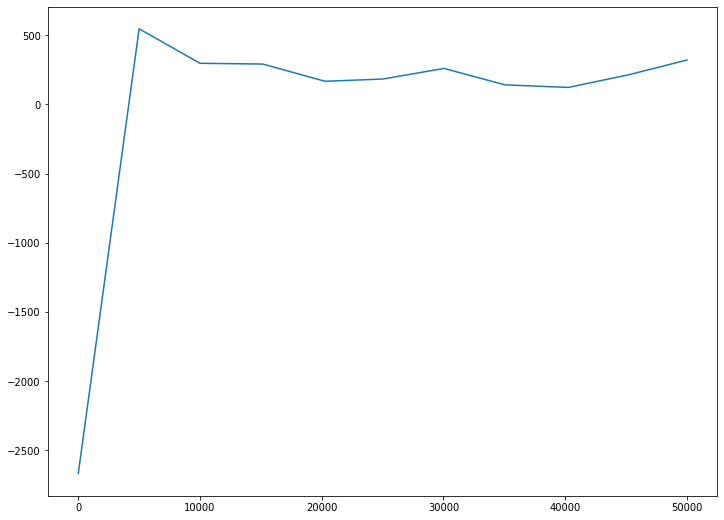

In [9]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.lineplot(evaluation_timesteps, evaluations, ax = ax)
plt.savefig('training_eval.png', bbox_inches = 'tight')

# Inference

In [10]:
monitor_dir = mkdir('.', 'monitor')
monitor_car_pov_dir = mkdir('.', 'monitor_car_pov')

# Env setup
inference_env_map = CityMap(citymap, roadmask, car_image_resized)
inference_env_map = wrappers.Monitor(inference_env_map, monitor_dir, force = True, video_callable=lambda episode_id: True)
inference_env_map.reset()

inference_env_car = CityMap(citymap, roadmask, car_image_resized, render_pov = 'car')
inference_env_car = wrappers.Monitor(inference_env_car, monitor_car_pov_dir, force = True, video_callable=lambda episode_id: True)
inference_env_car.reset();

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


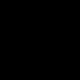

In [11]:
Image.fromarray( inference_env_car.unwrapped._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('L').resize((80,80))

In [0]:
# Loading the model
inference_policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device)
inference_policy.load(file_name, './pytorch_models/')

In [13]:
#Map POV
avg_reward_map = evaluate_policy(inference_policy, inference_env_map, eval_episodes=3)

# Wrapup recording
inference_env_map.close()
inference_env_map.stats_recorder.save_complete()
inference_env_map.stats_recorder.done = True

# #Car POV
avg_reward_car = evaluate_policy(inference_policy, inference_env_car, eval_episodes=3)

# Wrapup recording
inference_env_car.close()
inference_env_car.stats_recorder.save_complete()
inference_env_car.stats_recorder.done = True

---------------------------------------
Episode lengths:  [447, 138, 402]
Rewards per episode:  [351.6000000000011, 161.1, 210.49999999999991]
Average Reward over the Evaluation Step: 241.066667
Average action: -0.002584
Std deviation action: 0.978915
---------------------------------------
---------------------------------------
Episode lengths:  [229, 159, 275]
Rewards per episode:  [255.60000000000002, 176.0, 168.19999999999993]
Average Reward over the Evaluation Step: 199.933333
Average action: 0.025385
Std deviation action: 0.977751
---------------------------------------
